### Integrantes: Patricio Canales, Victor Moya, Eleazar Vásquez

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Mi primera Red Neuronal Bayesiana

Las redes neuronales son modelos del estado del arte para hacer regresión y clasificación con datos complejos

Generalmente estos modelos requieren de una gran cantidad de datos para poder entrenarlos de forma efectiva y sin que se sobreajusten. Sin embargo, en algunos problemas los datos disponibles son simplemente muy escasos o muy difíciles de obtener. Adicionalmente, no es directo tomar decisiones en base al modelo, y se requiere un paso adicional de calibración. ¿Cómo podemos confiar en las decisiones del modelo?

Podemos intentar solucionar estos problemas escribiendo la red neuronal como un modelo bayesiano y aprender el posterior de sus parámetros con un método de Markov Chain Monte Carlo (siempre y cuando el modelo sea simple). 

Incorporando priors el modelo estará regularizado y en lugar de estimadores puntuales tendremos la distribución a posteriori completa. Esta rica información extra nos permite medir la confianza del modelo sobre sus predicciones (el modelo sabe cuando no sabe) facilitando la tarea de calibración. 



## Formulación clásica

En esta tarea se pide que programen un modelo de red neuronal para clasificación de datos bidimensionales, de dos clases, con una capa oculta y con función de activación sigmoidal

Sea el conjunto de datos y etiquetas

$$
\mathcal{D} = \{(x, y)^{(i)}, i=1,2,\ldots,N\} \quad x^{(i)} \in \mathbb{R}^2,  y^{(i)} \in \{0, 1\}
$$

Consideremos ahora una tupla en particular $(X, Y)$. La salida de la capa oculta en notación matricial es

$$
Z = \text{sigmoide}( W_Z X + B_Z)
$$

donde $W_Z \in \mathbb{R}^{M \times 2}$, $B_Z \in \mathbb{R}^{M}$ y  $M$ es el tamaño de la capa oculta

La salida de la capa visible (última capa) en notación matricial es

$$
Y = \text{sigmoide}( W_Y Z + B_Y)
$$

donde $W_Y \in \mathbb{R}^{1 \times M}$, $B_Z \in \mathbb{R}$

La función sigmoide se define como

$$
\text{sigmoide}(x) = \frac{1}{1+ e^{-x}}
$$

Luego $Z$ es un vector de largo $M$ con valores en $[0, 1]$ e $Y$ es un escalar con valor en el rango $[0, 1]$

## Formulación bayesiana

Para darle un toque bayesiano a este modelo debemos

- Definir priors para $W_Z$, $B_Z$, $W_Y$ y $B_Y$. Se pide que utilice priors **normales con media cero y desviación estándar diez**.
- Definir una verosimilitud para le problema. Dado que el problema es de clasificación binaria, utilice una distribución de **Bernoulli** con $p=Y$
- Considere los datos $X$ como una variable determínista. 

## Indicaciones

Utilice

- El atributo `shape` para darle la dimensión correcta a cada variable cada uno
- El atributo `observed` para asignar las etiquetas reales a esta variable aleatoria observada
- `pm.Data` para la variable independiente
- `theano.tensor.sigmoid` para calcular la función sigmoide
- `A.dot(B)` para calcular el producto matricial entre `A` y `B`



## Instrucciones específicas

- Considere el dataset sintético `two-moons` que se muestra a continuación. Se pide que realice dos experimentos variando el valor de `n_samples`, primero a $100$ y finalmente a $10$
- Implemente el modelo de red neuronal bayesiana en `pymc3` dejando $M$ como un argumento. Para cada valor de `n_samples` entrene tres modelos con $M=1$, $M=3$ y $M=10$
- Seleccione y calibre un algoritmo de MCMC para entrenar este modelo. Justifique y respalde sus decisiones en base al comportamiento de las trazas, al estadístico Gelman-Rubin y a la función de autocorrelación
- Estudie el posterior de los parámetros y evalue el posterior predictivo sobre los datos de prueba. Muestre graficamente la media y la varianza del posterior predictivo en el espacio de los datos. Haga observaciones y comparaciones entre los 6 casos (3 valores de $M$ y 2 valores de `n_samples`)

## Imports y creación de datos

In [ ]:
!pip3 install pygdm2

In [ ]:
!pip3 install arviz
!pip3 install pymc3==3.8

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from warnings import filterwarnings
filterwarnings("ignore")

Hint: Si `model_preds` es el posterior predictivo en el conjunto de test donde la primera dimensión son las muestras y la segunda dimensión los ejemplos, podemos graficar la media de ese posterior como:

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1, x2, np.mean(post_pred['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

## Genera y dibuja datos

In [ ]:
def genera_datos(n_samples):
  x, y = make_moons(n_samples, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
  x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)
  return x,y

In [ ]:
def dibuja_datos(x,y):
  fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
  ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
  ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

  x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                      np.linspace(-3, 3, 100))
  x_test = np.vstack([x1.ravel(), x2.ravel()]).T
  fig.show()


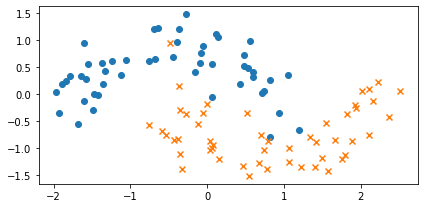

In [ ]:
x,y = genera_datos(100)
dibuja_datos(x,y)

## Red Neuronal Bayesiana

In [ ]:
def construct_nn(X_shared,Y_shared, M = 1):
    
  init_bz=np.random.randn(1, M)
  init_wz=np.random.randn(2, M)
  init_by=np.random.randn()
  init_wy=np.random.randn(M, 1)

  with pm.Model() as neural_network:
        
    X_ = pm.Data("x", X_shared)
    Y = pm.Data("y", Y_shared)
        
    # priors
    bz = pm.Normal('bz', mu=0, sd=10, shape=(M))
    wz = pm.Normal('wz', mu=0, sd=10, shape=(2, M))
    by = pm.Normal('by', mu=0, sd=10, shape=1 )
    wy = pm.Normal('wy', mu=0, sd=10, shape=(M,1))
 
    # Salida de la capa oculta
    Z_forward = theano.tensor.nnet.sigmoid(T.dot(X_,wz)+bz)
    # Salida de ultima capa
    Y_forward = theano.tensor.nnet.sigmoid(T.dot(Z_forward,wy)+by)
        
    # Verosimilitud con distribucion Bernoulli
    out = pm.Bernoulli("out", p=Y_forward, observed=Y)
  


  return neural_network


# Sample=10, M=1

In [ ]:
x, y = genera_datos(10)
neural_network_s10_M1 = construct_nn(x,y,1)

In [ ]:
with neural_network_s10_M1:
  trace_10_1 = pm.sample(draws=4000, tune=2000,cores=2,chains=2, step=pm.NUTS(target_accept=.99))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [03:41<00:00, 54.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


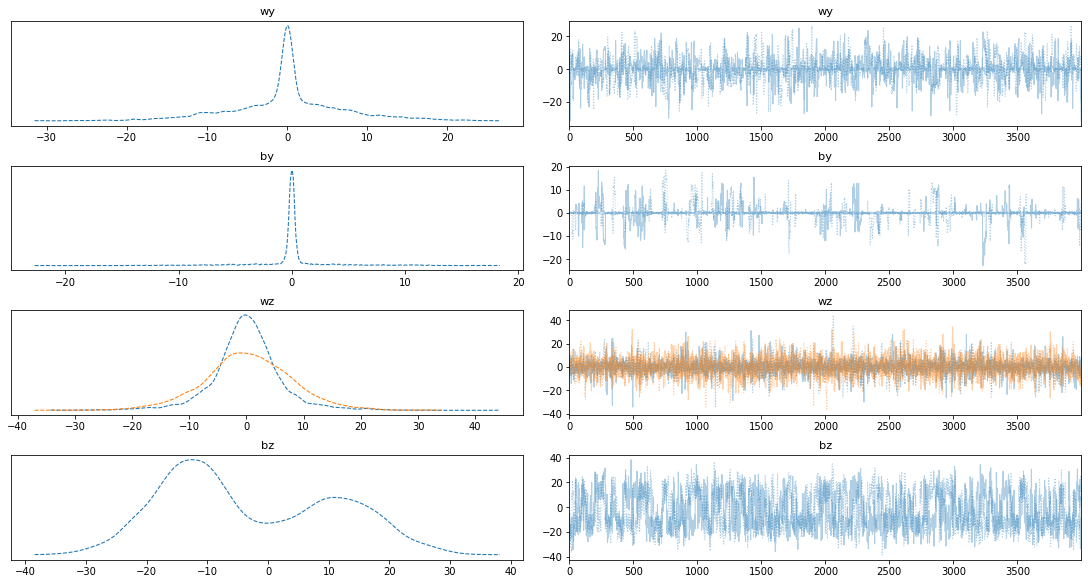

In [ ]:
pm.traceplot(trace_10_1, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

In [ ]:
pm.summary(trace_10_1, var_names=['bz', 'wz', 'by', 'wy']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bz[0],-0.247,14.738,-24.634,23.689,1.062,0.752,193.0,193.0,233.0,1438.0,1.00
"wz[0,0]",0.090,5.850,-10.908,12.726,0.146,0.147,1606.0,794.0,1778.0,1163.0,1.00
"wz[1,0]",-0.224,7.570,-14.610,13.955,0.184,0.130,1702.0,1697.0,1716.0,2218.0,1.00
by[0],-0.087,4.073,-10.492,8.057,0.266,0.204,234.0,201.0,249.0,329.0,1.01
"wy[0,0]",0.144,6.848,-13.897,14.022,0.308,0.218,495.0,495.0,457.0,841.0,1.01


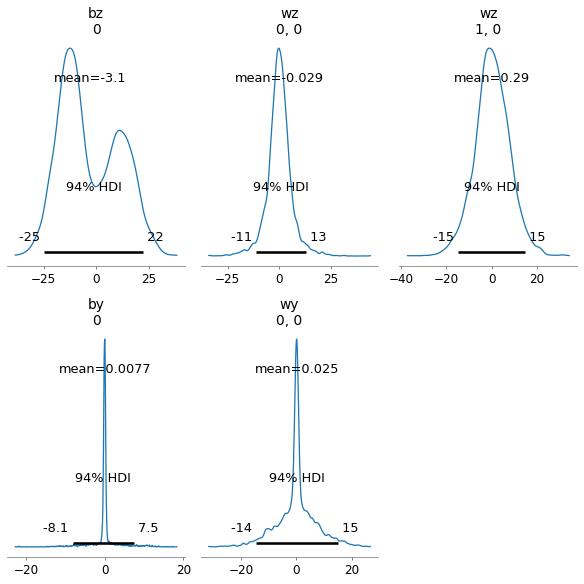

In [ ]:
pm.plot_posterior(trace_10_1, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

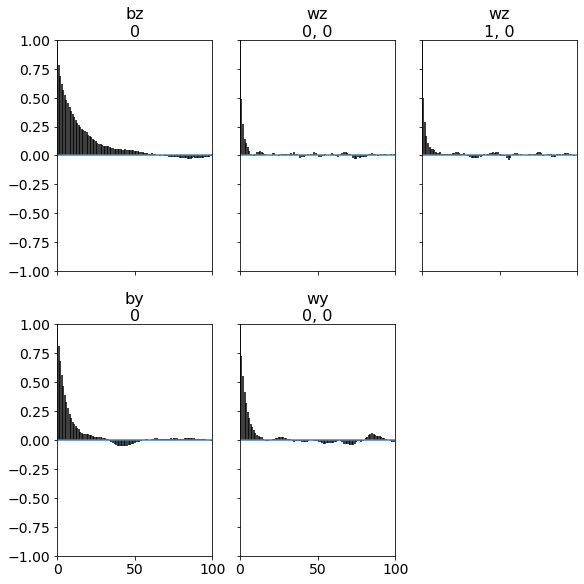

In [ ]:
pm.plots.autocorrplot(trace_10_1, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# Sample=10, M=3

In [ ]:
x, y = genera_datos(10)
neural_network_s10_M3 = construct_nn(x,y,3)

In [ ]:
with neural_network_s10_M3:
  trace_10_3 = pm.sample(draws=3000, tune=2000,cores=2,chains=2, step=pm.NUTS(target_accept=.99))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [08:23<00:00, 19.86draws/s]
The number of effective samples is smaller than 25% for some parameters.


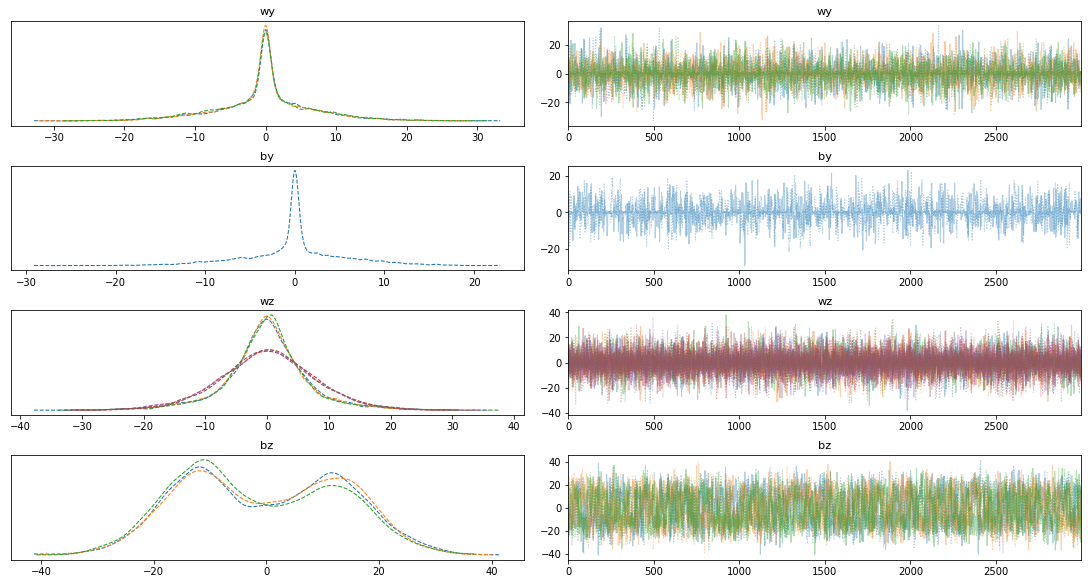

In [ ]:
pm.traceplot(trace_10_3, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

In [ ]:
pm.summary(trace_10_3, var_names=['bz', 'wz', 'by', 'wy']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bz[0],-0.258,14.284,-23.938,24.343,0.517,0.366,764.0,764.0,839.0,2904.0,1.0
bz[1],-0.234,14.121,-23.923,23.431,0.536,0.379,694.0,694.0,751.0,2467.0,1.0
bz[2],-1.640,14.025,-24.282,23.187,0.514,0.364,743.0,743.0,815.0,2586.0,1.0
"wz[0,0]",-0.009,7.049,-15.137,13.845,0.158,0.125,1987.0,1589.0,2214.0,1942.0,1.0
"wz[0,1]",-0.130,6.882,-14.184,14.142,0.142,0.125,2351.0,1522.0,2460.0,2206.0,1.0
"wz[0,2]",-0.013,6.922,-15.439,12.961,0.140,0.110,2462.0,1990.0,2665.0,2659.0,1.0
"wz[1,0]",0.163,7.853,-14.283,15.687,0.155,0.109,2579.0,2579.0,2605.0,3162.0,1.0
"wz[1,1]",-0.026,8.085,-15.644,15.610,0.145,0.129,3107.0,1963.0,3085.0,2802.0,1.0
"wz[1,2]",0.181,7.859,-14.747,15.104,0.141,0.109,3104.0,2605.0,3130.0,3347.0,1.0
by[0],0.070,5.490,-11.187,11.571,0.120,0.097,2094.0,1593.0,2108.0,2588.0,1.0


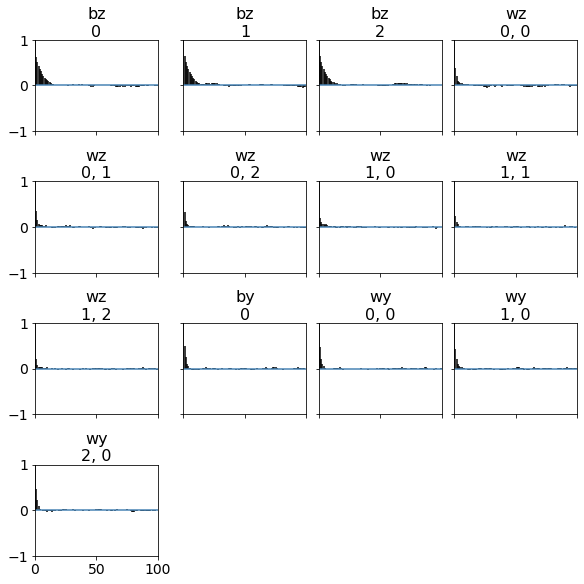

In [ ]:
pm.plots.autocorrplot(trace_10_3, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# Sample=10, M=10

In [ ]:
x, y = genera_datos(10)
neural_network_s10_M10 = construct_nn(x,y,10)

In [ ]:
with neural_network_s10_M10:
  trace_10_10 = pm.sample(draws=3000, tune=1000,cores=2,chains=2, step=pm.NUTS(target_accept=.99, max_treedepth=12))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [15:14<00:00,  8.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


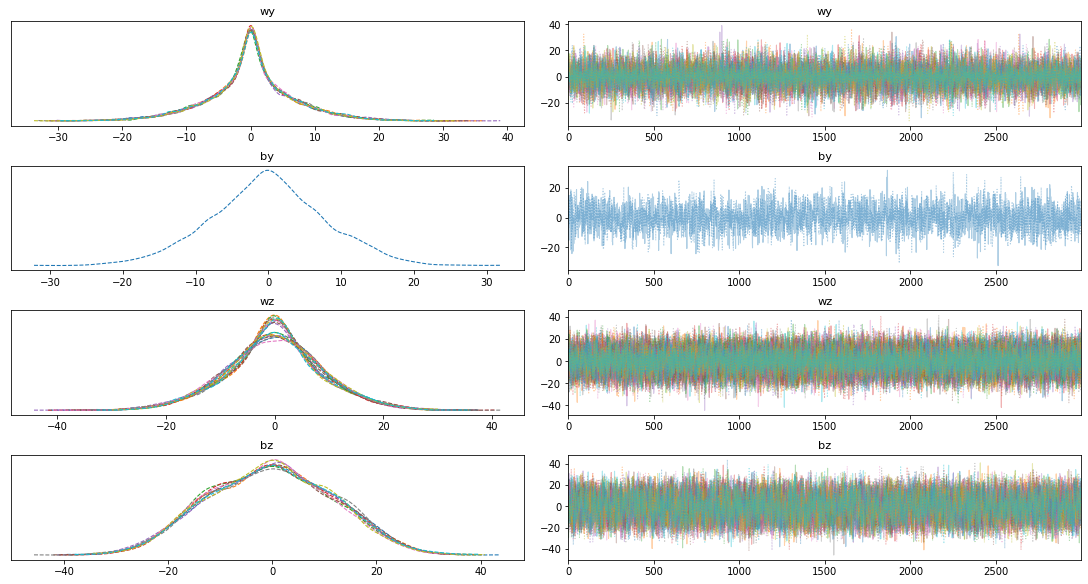

In [ ]:
pm.traceplot(trace_10_10, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

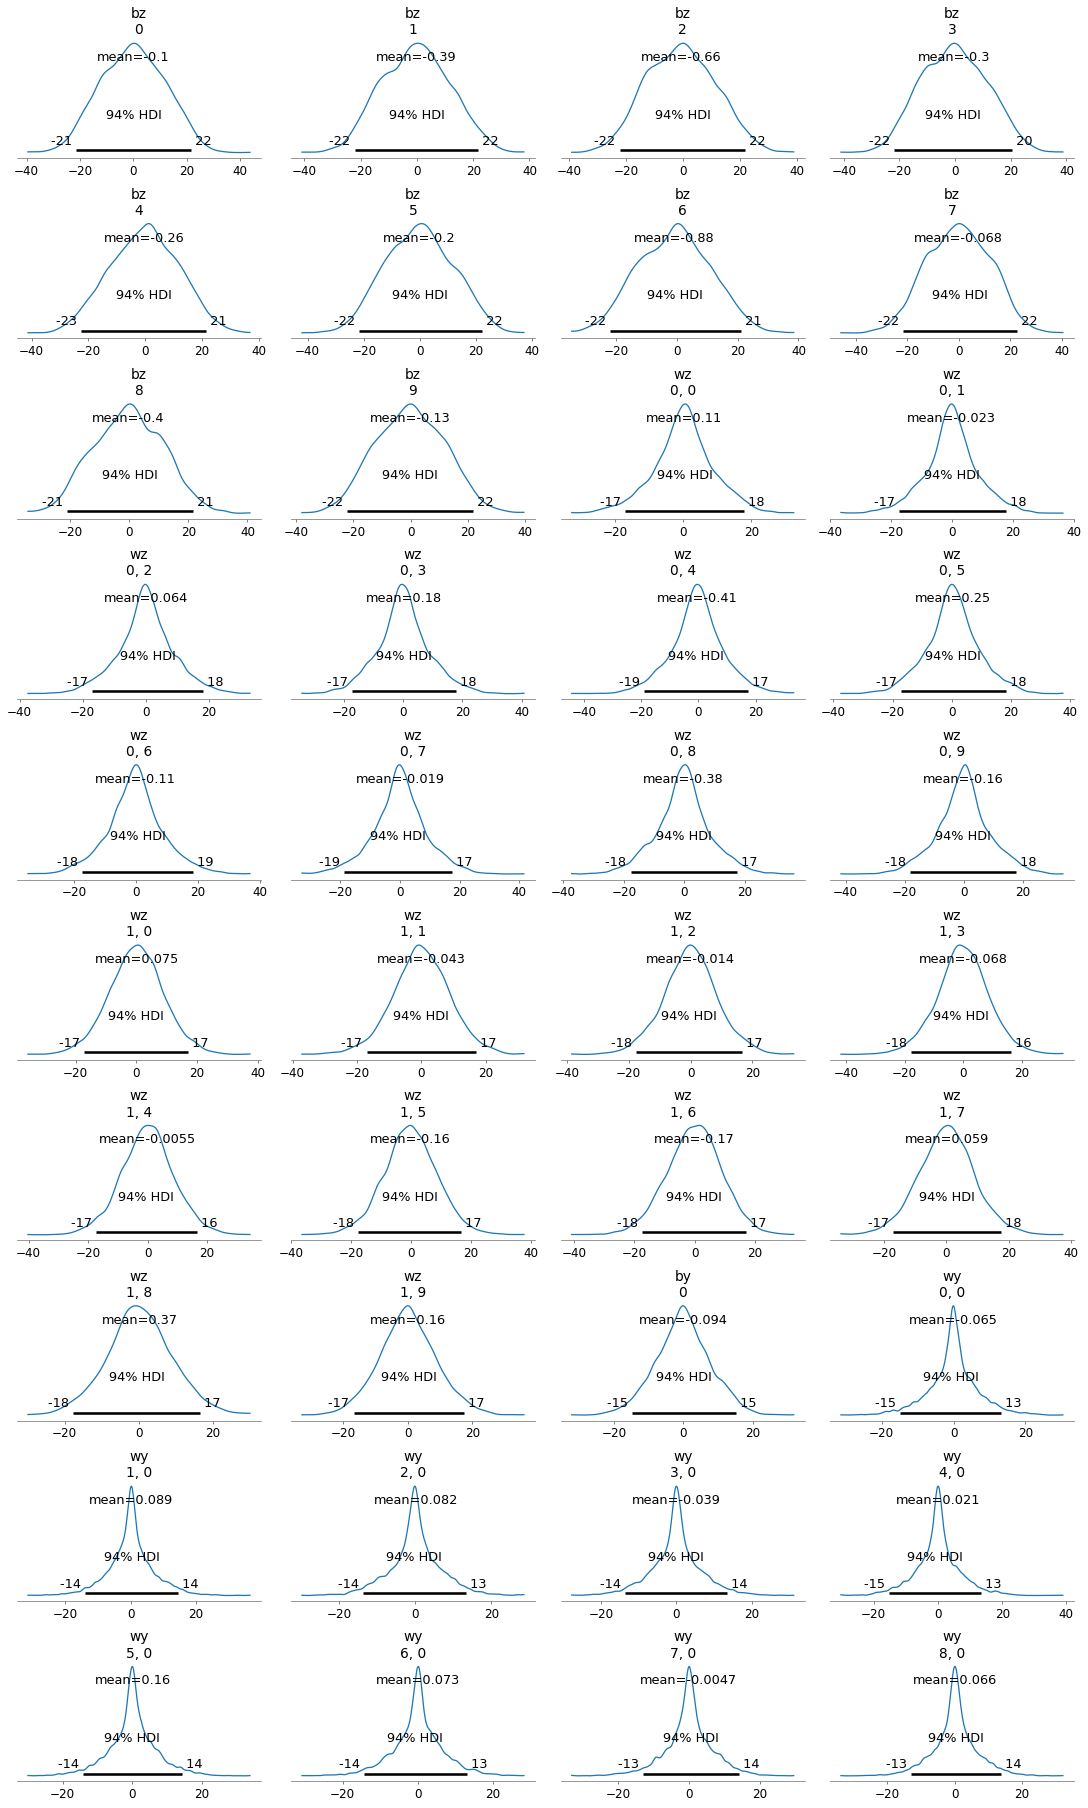

In [ ]:
pm.plot_posterior(trace_10_10, figsize=(15, 25), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [ ]:
pm.summary(trace_10_10, var_names=['bz', 'wz', 'by', 'wy']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bz[0],-0.100,11.967,-21.500,21.863,0.354,0.251,1141.0,1141.0,1174.0,3578.0,1.0
bz[1],-0.392,12.056,-22.185,21.877,0.347,0.245,1208.0,1208.0,1238.0,3245.0,1.0
bz[2],-0.657,12.042,-22.242,21.844,0.330,0.234,1328.0,1328.0,1350.0,3269.0,1.0
bz[3],-0.305,11.857,-22.009,20.476,0.340,0.240,1218.0,1218.0,1251.0,3399.0,1.0
bz[4],-0.262,12.022,-22.592,21.478,0.341,0.241,1241.0,1241.0,1262.0,3143.0,1.0
bz[5],-0.204,12.002,-21.757,22.024,0.373,0.264,1038.0,1038.0,1054.0,2823.0,1.0
bz[6],-0.881,11.792,-22.021,21.027,0.354,0.251,1107.0,1107.0,1133.0,3190.0,1.0
bz[7],-0.068,12.192,-21.778,22.471,0.381,0.270,1023.0,1023.0,1041.0,3226.0,1.0
bz[8],-0.399,11.740,-21.187,21.436,0.329,0.232,1277.0,1277.0,1301.0,3493.0,1.0
bz[9],-0.129,12.089,-22.279,21.651,0.345,0.244,1226.0,1226.0,1238.0,2889.0,1.0


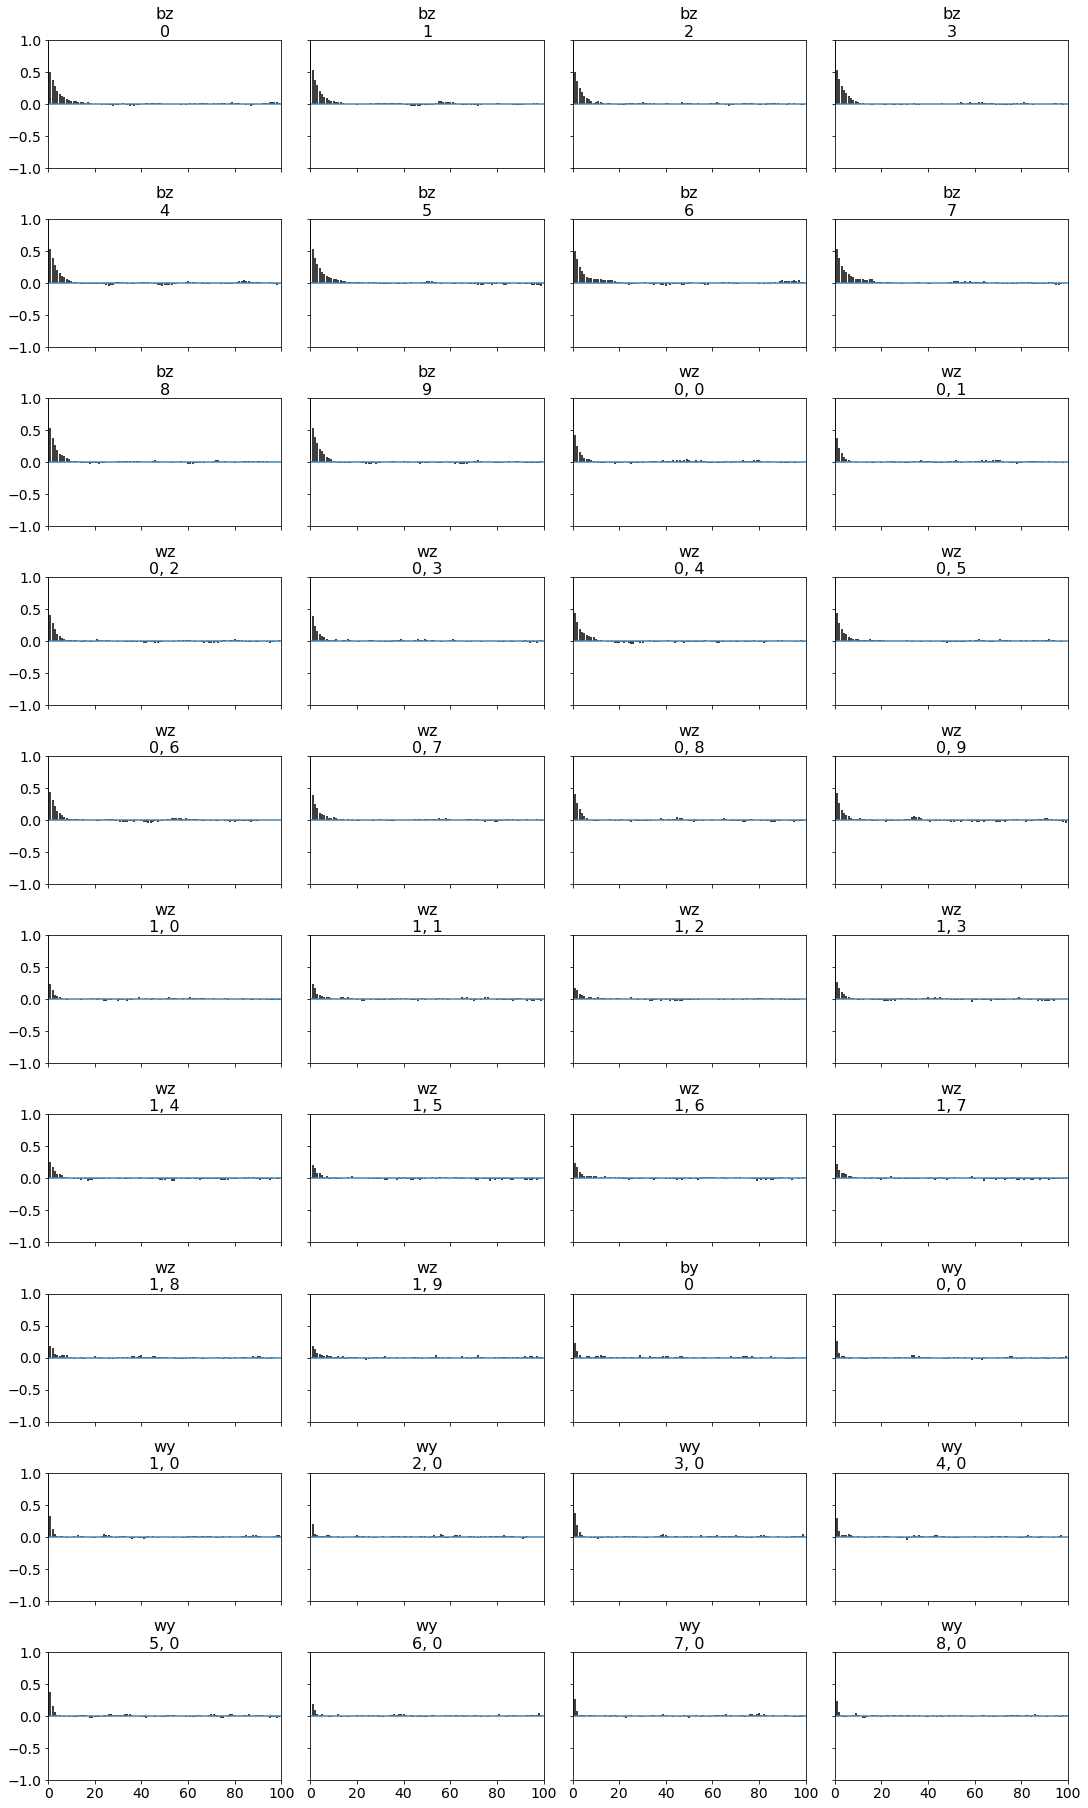

In [ ]:
pm.plots.autocorrplot(trace_10_10, figsize=(15, 25), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# Sample 100, M=1

In [ ]:
x, y = genera_datos(100)
neural_network_s100_M1 = construct_nn(x,y,1)

In [ ]:
with neural_network_s100_M1:
    trace_100_1 = pm.sample(draws=4000, tune=1500,cores=2,chains=2, step=pm.NUTS(target_accept=.99, max_treedepth=12))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 38 divergences: 100%|██████████| 11000/11000 [17:05<00:00, 10.73draws/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


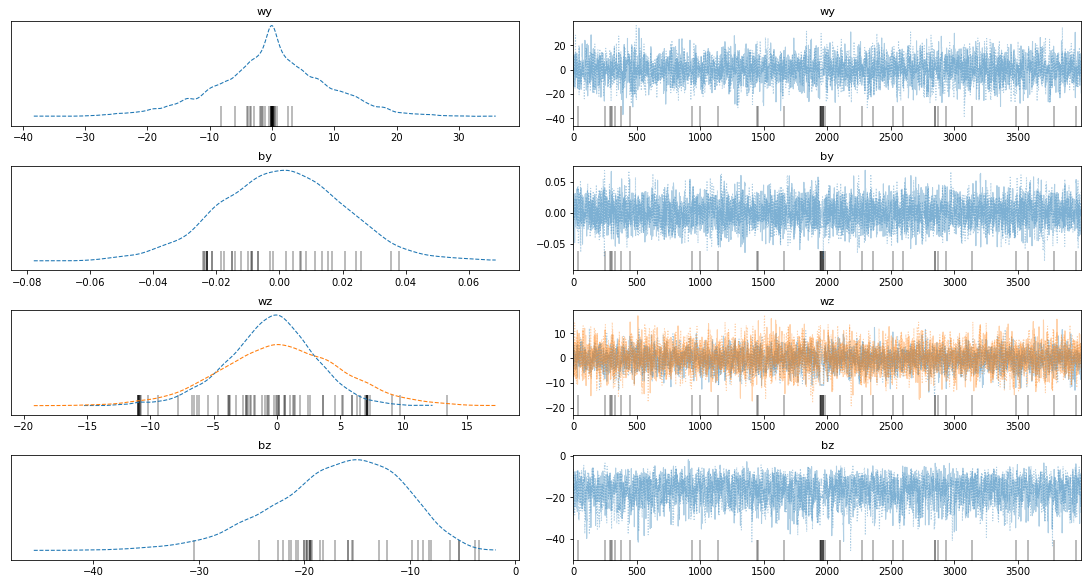

In [ ]:
pm.traceplot(trace_100_1, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

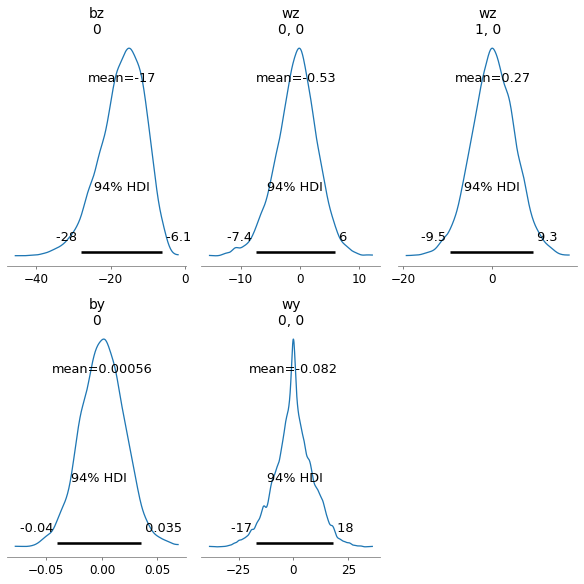

In [ ]:
pm.plot_posterior(trace_100_1, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [ ]:
pm.summary(trace_100_1, var_names=['bz', 'wz', 'by', 'wy']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bz[0],-16.925,6.054,-27.962,-6.106,0.127,0.090,2263.0,2263.0,2249.0,3301.0,1.0
"wz[0,0]",-0.530,3.530,-7.409,5.957,0.083,0.069,1805.0,1312.0,1975.0,1564.0,1.0
"wz[1,0]",0.274,4.918,-9.470,9.265,0.091,0.064,2937.0,2937.0,2928.0,3747.0,1.0
by[0],0.001,0.020,-0.040,0.035,0.000,0.000,4403.0,3062.0,4403.0,4139.0,1.0
"wy[0,0]",-0.082,9.081,-17.057,18.116,0.156,0.119,3390.0,2909.0,3413.0,3661.0,1.0


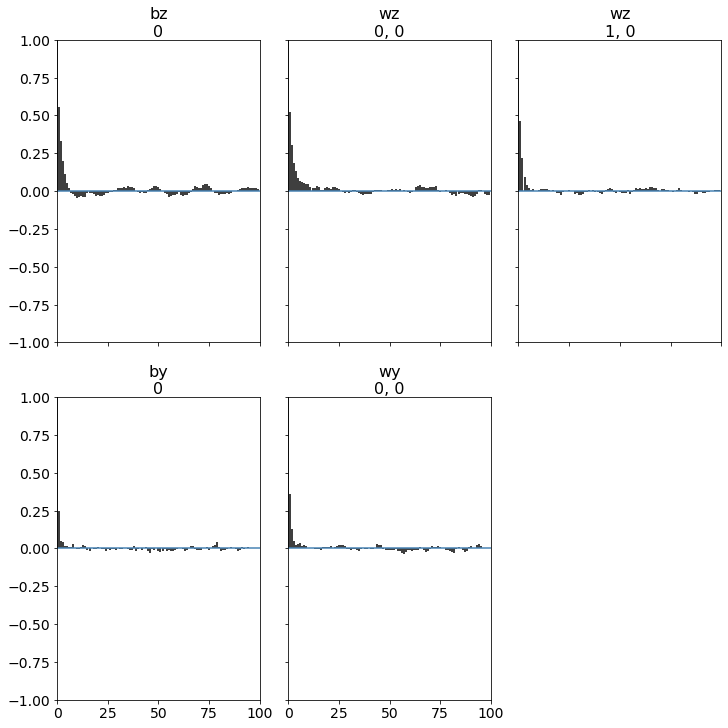

In [ ]:
pm.plots.autocorrplot(trace_100_1, figsize=(10, 10), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# sample 100, M=3

In [ ]:
x, y = genera_datos(100)
neural_network_s100_M3 = construct_nn(x,y,3)

In [ ]:
with neural_network_s100_M3:
    trace_100_3 = pm.sample(draws=2000, tune=1000,cores=2,chains=2, step=pm.NUTS(target_accept=.99, max_treedepth=12))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [1:32:12<00:00,  1.08draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


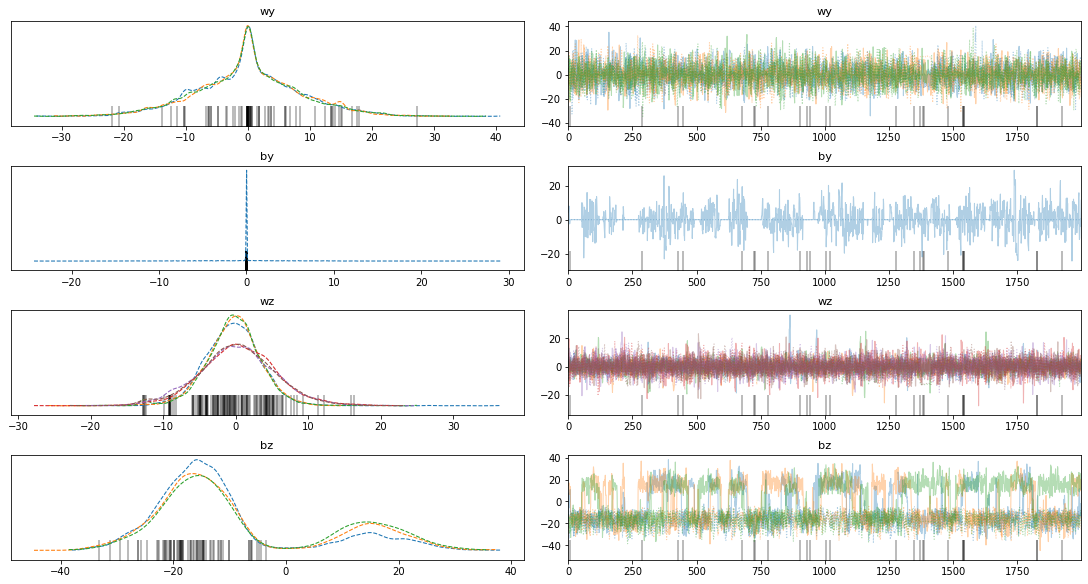

In [ ]:
pm.traceplot(trace_100_3, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

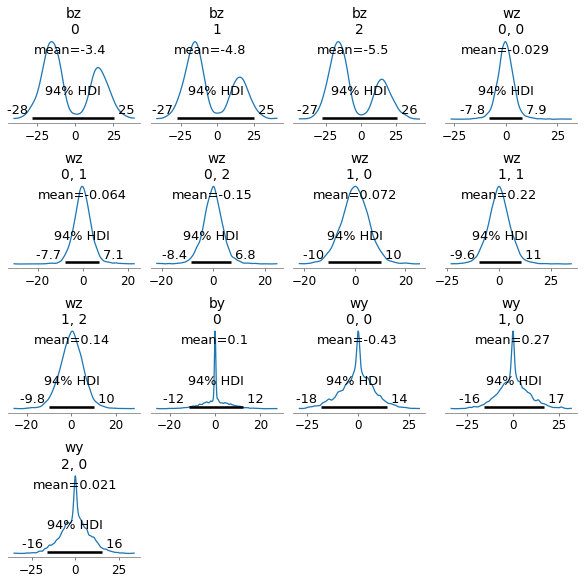

In [ ]:
pm.plot_posterior(trace, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [ ]:
pm.summary(trace_100_3, var_names=['bz', 'wz', 'by', 'wy']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bz[0],-11.280,13.636,-29.529,20.810,3.391,2.443,16.0,16.0,26.0,126.0,1.08
bz[1],-8.739,15.471,-28.367,23.561,5.692,4.195,7.0,7.0,12.0,69.0,1.14
bz[2],-7.220,15.928,-28.497,23.173,7.792,5.948,4.0,4.0,6.0,28.0,1.28
"wz[0,0]",-0.325,3.979,-7.343,6.764,0.118,0.096,1137.0,863.0,1245.0,1289.0,1.00
"wz[0,1]",-0.392,3.814,-6.988,7.218,0.100,0.081,1447.0,1107.0,1579.0,1312.0,1.00
"wz[0,2]",-0.296,4.051,-7.572,7.266,0.172,0.144,554.0,395.0,747.0,370.0,1.01
"wz[1,0]",0.439,5.337,-8.872,11.586,0.122,0.091,1924.0,1709.0,1893.0,2043.0,1.01
"wz[1,1]",0.093,5.400,-9.827,10.319,0.169,0.120,1019.0,1019.0,1056.0,814.0,1.00
"wz[1,2]",0.196,5.293,-9.770,10.748,0.167,0.140,1004.0,713.0,1119.0,404.0,1.00
by[0],-0.006,4.593,-10.121,10.181,0.108,0.803,1800.0,17.0,2019.0,68.0,1.43


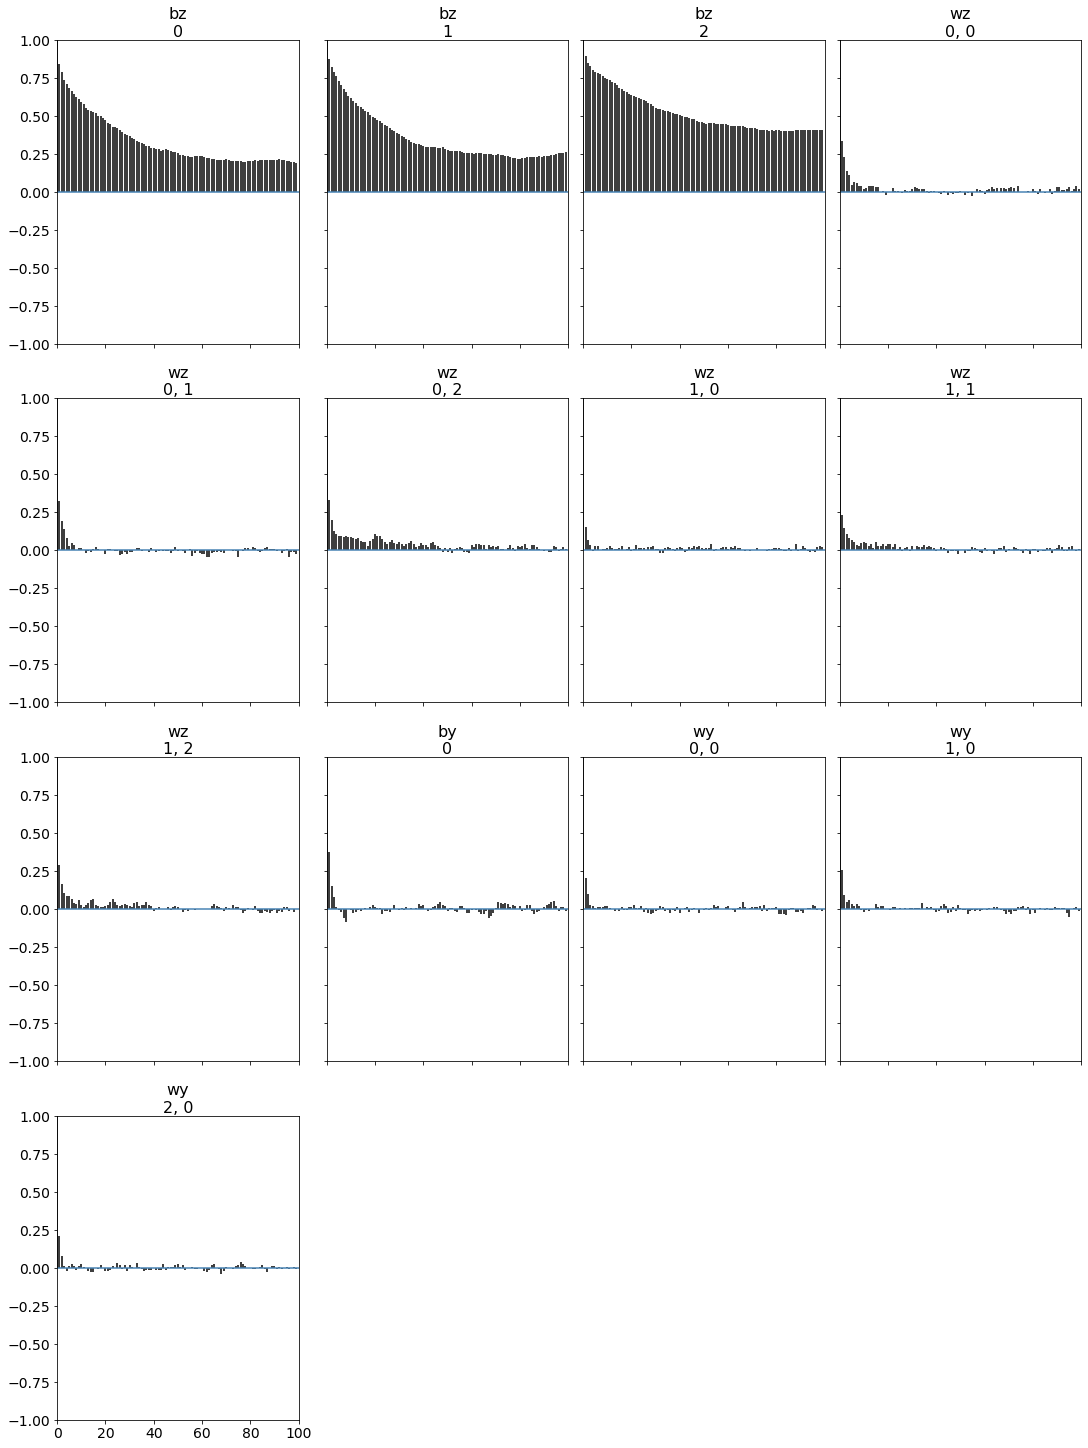

In [ ]:
pm.plots.autocorrplot(trace_100_3, figsize=(15, 20), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# sample 100, M=10

In [ ]:
x, y = genera_datos(100)
neural_network_s10_M1 = construct_nn(x,y,10)

In [ ]:
with neural_network_s10_M1:
    trace = pm.sample(draws=2000, tune=500,cores=2,chains=2, step=pm.NUTS(target_accept=.9))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:59<00:00, 16.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


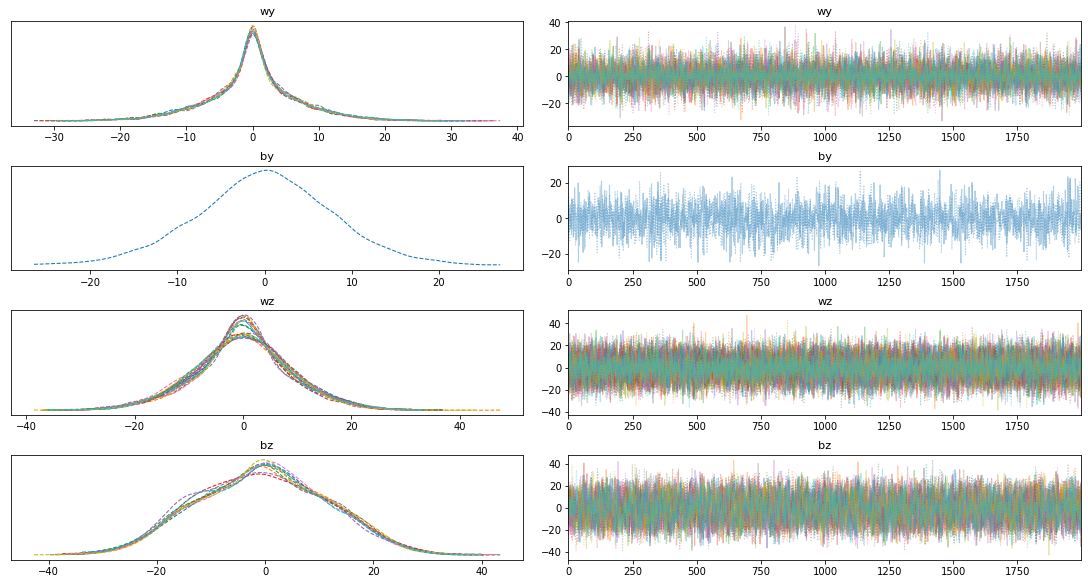

In [ ]:
pm.traceplot(trace, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

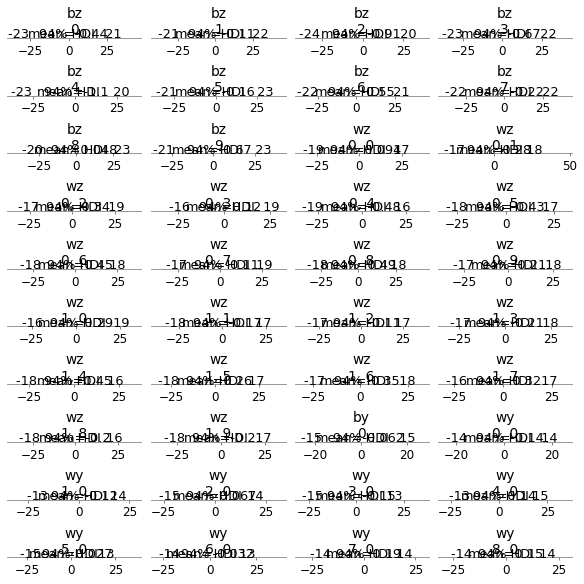

In [ ]:
pm.plot_posterior(trace, figsize=(15, 15), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [ ]:
pm.summary(trace, var_names=['bz', 'wz', 'by', 'wy']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bz[0],-0.440,11.848,-22.962,20.939,0.395,0.279,900.0,900.0,906.0,1566.0,1.00
bz[1],-0.114,12.080,-21.367,22.291,0.425,0.301,807.0,807.0,815.0,2300.0,1.00
bz[2],-0.908,12.043,-23.753,20.226,0.476,0.337,641.0,641.0,659.0,1937.0,1.00
bz[3],-0.665,12.238,-22.680,21.665,0.420,0.297,848.0,848.0,864.0,1965.0,1.00
bz[4],-1.094,12.043,-23.316,20.227,0.427,0.302,795.0,795.0,815.0,2074.0,1.00
bz[5],-0.162,12.001,-21.025,22.840,0.415,0.293,837.0,837.0,861.0,2460.0,1.00
bz[6],-0.546,11.802,-21.946,21.084,0.422,0.299,780.0,780.0,794.0,2225.0,1.00
bz[7],-0.222,12.132,-22.423,21.752,0.463,0.327,687.0,687.0,696.0,1933.0,1.00
bz[8],0.048,11.926,-20.001,23.027,0.420,0.297,807.0,807.0,815.0,2168.0,1.00
bz[9],-0.671,11.973,-21.080,22.931,0.427,0.302,786.0,786.0,798.0,1810.0,1.00


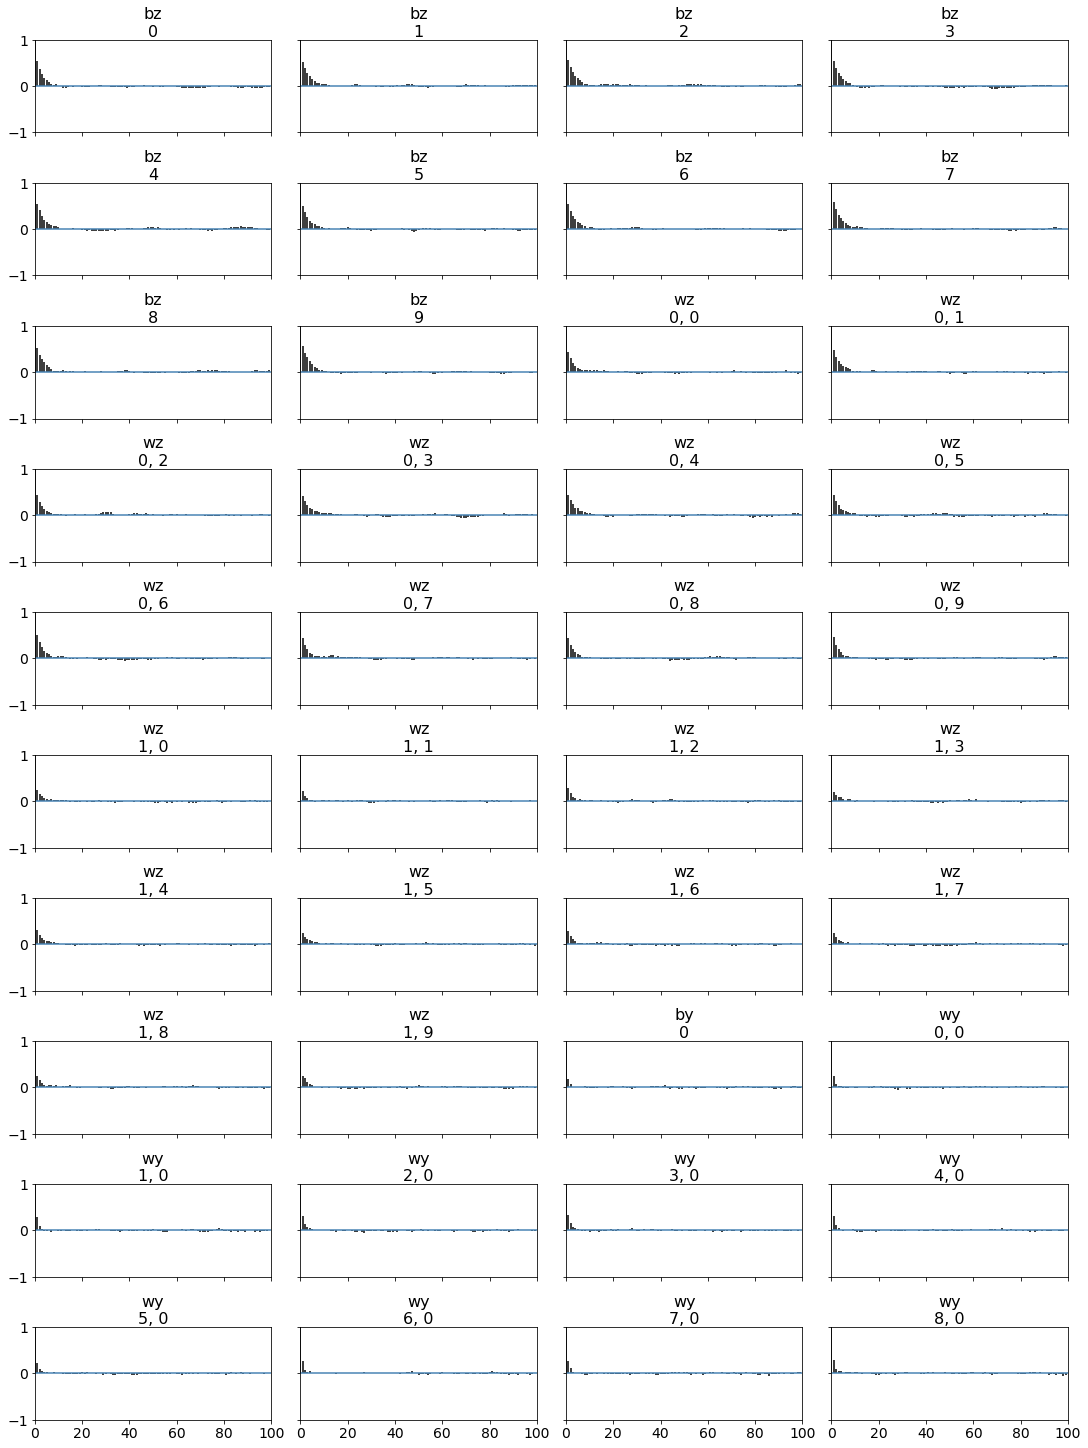

In [ ]:
pm.plots.autocorrplot(trace, figsize=(15, 20), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

## Observaciones

Definimos los priors con el tamaño adecuado para que el funcionamiento de la red sea el adecuado, en este caso "dimos vuelta" las dimensiones de wz y zy para poder efectuar la multiplicación de matrices más adelantes, ya que intentamos trasponer la matriz pero no nos resultó, esta acción no debería generar problemas con el resultado final. Por otro lado, nos guíamos de la siguiente referencia para las especificaciones del modelo: [Bayesian Neural Networks](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)

## Obteniendo muestras de las trazas

In [ ]:
?pm.NUTS

In [ ]:
with neural_network:
    #start, step = pm._get_start_and_step()
    #step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=500, tune=300,cores=4,chains=2, step=pm.NUTS(target_accept=.95))
    

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 21 divergences: 100%|██████████| 1600/1600 [00:30<00:00, 53.25draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8326ad198>,
      dtype=object)

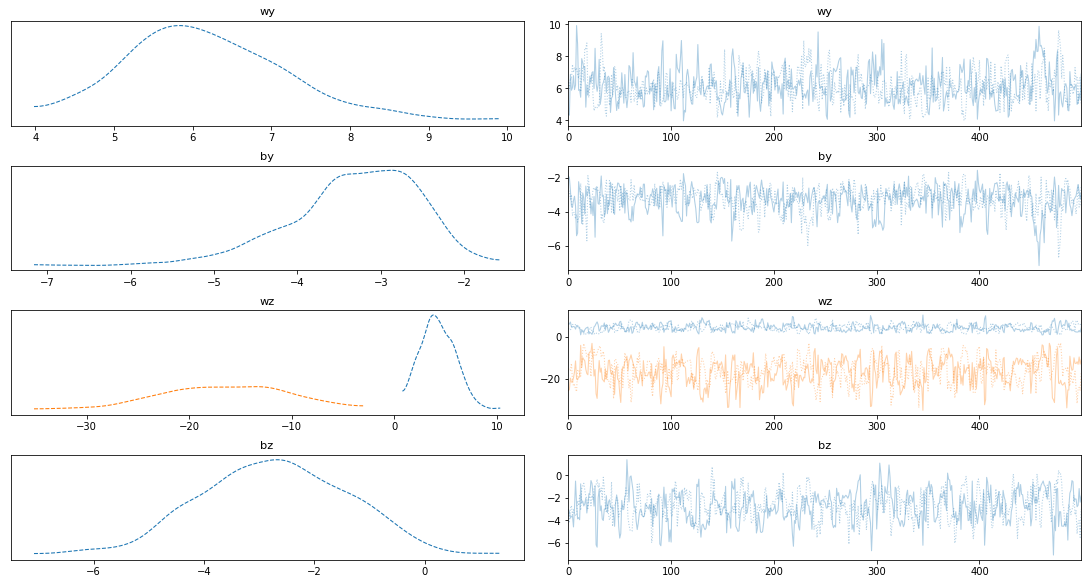

In [ ]:
pm.traceplot(trace, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


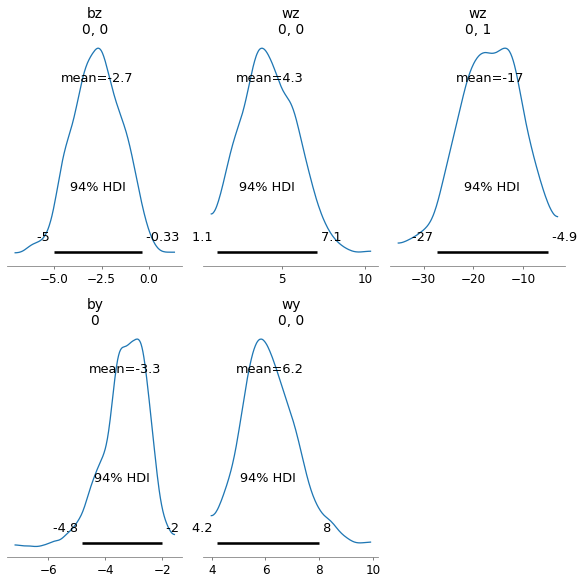

In [ ]:
pm.plot_posterior(trace, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [ ]:
pm.summary(trace, var_names=['bz', 'wz', 'by', 'wy']).round(3)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",-2.729,1.322,-5.020,-0.328,0.072,0.051,340.0,340.0,338.0,541.0,1.01
"wz[0,0]",4.284,1.681,1.121,7.091,0.096,0.068,304.0,304.0,298.0,446.0,1.01
"wz[0,1]",-16.686,6.229,-27.393,-4.950,0.354,0.250,310.0,310.0,307.0,471.0,1.01
by[0],-3.309,0.778,-4.821,-1.993,0.043,0.032,325.0,293.0,375.0,305.0,1.00
"wy[0,0]",6.170,1.019,4.187,7.982,0.053,0.039,364.0,344.0,391.0,381.0,1.00


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


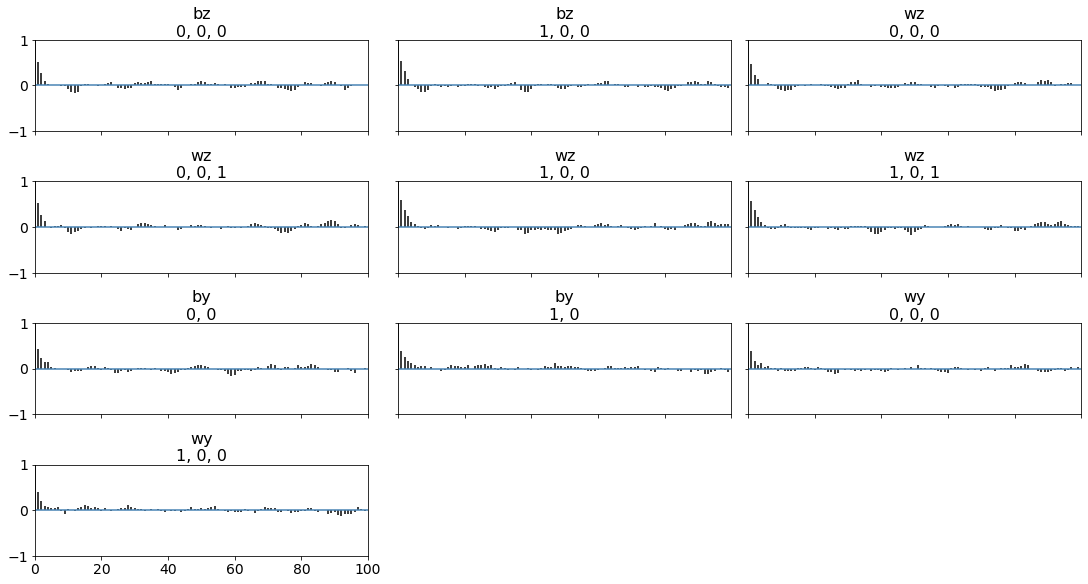

In [ ]:
pm.plots.autocorrplot(trace, figsize=(15, 8), 
                      var_names=['bz', 'wz', 'by', 'wy']);

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

2

In [ ]:
neural_network

In [ ]:
type(neural_network)

pymc3.model.Model

In [ ]:
x

In [ ]:
x.T.shape

(2, 100)

In [ ]:
y

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1])

In [ ]:
x[0]

array([-0.28289561,  1.47501984])

In [ ]:
x.shape[1]

2

In [ ]:
type(neural_network)

pymc3.model.Model

In [ ]:
with neural_network:
    # For good
    pm.set_data({'x': x_test})
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:46<00:00, 10.78it/s]


In [ ]:
model_pred=np.array(post_pred['out'][0],post_pred['out'][2])

TypeError: ignored

In [ ]:
post_pred['out'].shape

(500, 10000, 100)

In [ ]:
post_pred[]

{'out': array([[[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 0, 1],
         [0, 1, 1, ..., 1, 1, 1],
         [0, 1, 1, ..., 0, 0, 0]],
 
        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [0, 0, 1, ..., 0, 0, 1],
         [1, 1, 1, ..., 1, 1, 0],
         [1, 0, 1, ..., 1, 1, 0]],
 
        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [0, 1, 0, ..., 0, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 0, 1, ..., 0, 1, 0],
         [0, 0, 1, ..., 0, 0, 1]],
 
        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1,

In [ ]:
x.shape

(100, 2)

In [ ]:
y.shape

(100,)

In [ ]:
x_test.shape

(10000, 2)